In [44]:
import micasense.imageset as imageset
import micasense.capture as capture
import os, glob
import json
import pickle #This library will maintain the format as well
import importlib
import radiometric_calib_utils
import mutils
importlib.reload(radiometric_calib_utils)
importlib.reload(mutils)
import radiometric_calib_utils as rcu
import mutils
import matplotlib.pyplot as plt
import numpy as np

# Radiometric calibration and correction

This notebook aims to create a calibration curve for radiometric correction under different illumination conditions. Without effective radiometric calibration, drone imagery heavily suffers from sun illumination affected by time of day, cloud, and other weather conditions. UAV sensors are vulnerable to vibration and wind effect during flight. Their radiometric properties may also be impacted by other environmental variations such as temperature, solar illumination, and weather conditions. Therefore, even with calibrated sensors, in situ calibration is often needed to improve accuracies of quantitative applications.

The most common in situ calibration approach is the Empirical Line Method (ELM) to build the relationships between the reflectance of calibrated targets and their top-of-atmosphere radiance (at sensor radiance). It requires the real-time reflectance measurements of multiple artificial or natural targets. Some studies explored the irradiance-based ELM calibration by considering the aerosol effects in the relationship. This empirical calibration is often time consuming and not practical efficient. The real-time field spectra may not be needed when a reference standard is employed in field. The RedEdge system utilises a pre-calibration reflectance panel (CRP) set up in field and a Downwelling Light Sensor (DLS) mounted atop a drone to capture the hemispherical irradiance during the flight. The current procedure of RedEdge image correction mostly utilises the CRP panel itself and some studies have reported the relatively higher percent errors of its radiometric calibration. With the bar code embedded on the panel, the CRP reflectance can be automatically recognised in image processing packages.

## Radiometric calibration model

A radiometric calibration model has been has been developed to convert the raw pixel values into absolute spectral radiance:

$$ L = V(x,y) \cdot \frac{a_1}{g} \cdot \frac{p - p_{BL}}{t_e + a_2 y -a_3 t_e y}$$

Where,

- $p$ is the normalised raw pixel value (0 to 1 by dividing DN with the number of bits)
- $p_{BL}$ is the normalised black level value (can be found in metadata tags). This tag encodes an array of 4 values, which should be averaged to compute a black level offset which can be applied to all pixels
- $a_1, a_2, a_3$ are the radiometric calibration coefficients (to convert DN to radiance)
- $V(x,y)$ is the vignette polynomial function for pixel location (x,y). See "Vignette Model" section
- $t_e$ is the image exposure time
- $g$ is the sensor gain setting (can be found in metadata tags)
- $x, y$ are the pixel column and row number, respectively
- $L$ is the spectral radiance in $W/m^2/sr/nm$

## Vignette Model

The RedEdge uses a radial vignette model to correct for the fall-off in light sensitivity that occurs in pixels further from the center of the image. To apply the model, first read $cx, cy$ and the six polynomial coefficients from the image metadata, then compute the formula below to find a correction scale factor for each pixel intensity

$r = \sqrt{(x-c_x)^2 + (y-c_y)^2}$

$k = 1 + k_0 * r + k_1 * r^2 + k_2 * r^3 + k_3 * r^4 + k^4 * r^5 + k_5 * r^6$

$I_{corrected}(x,y) = \frac{I(x,y)}{k}$

Where,

- $r$ is the distance of the pixel (x,y) from the vignette center, in pixels
- $(x,y)$ is the coordinate of the pixel being corrected
- $k$ is the correction factor by which the raw pixel value should be divided to correct for vignette
- $I(x,y)$ is the original intensity of pixel at $x,y$
- $I_{corrected}(x,y)$ is the corrected intensity of pixel at x,y

In the radiance model above, $V(x,y)$ is equal to $1/k$

## Radiometric Correction

The radiance after calibration is further converted to surface reflectance for spectral analysis. Assisted with a pre-calibrated CRP panel, the surface reflectance ($\rho$) of the RedEdge-M image can be simply converted as:

$$ \rho(\lambda) = \frac{\rho_{CRP}}{L_{CRP}} \times L(\lambda) \quad (1)$$

Where,
- $\frac{\rho_{CRP}}{L_{CRP}}$ is the reflectance calibration factor to convert radiance of an image to reflectance
- $\rho_{CRP}$ is the pre-calibrated reflectance of the CRP panel
- $L_{CRP}$ is the average radiance of the CRP panel
- $\rho(\lambda)$ is the reflectance of an image of interest
- $L$ is the radiance of an image of interest

These micasense imageprocessing tool scan the QR code and identify a squared area within the CRP panel, then calculate the average radiance. The reflectance calibration factor is applied to all pixels of the image to extract surface reflectance

This approach is easy to use and works well when the relative biophysical quantities are of major concern. However, the radiometric correction relies on one single panel with a pre-determined constant coefficient for each band. In field, the panel's reflectance may be affected by solar illumination and path scattering that vary with time and atmospheric and environmental conditions. Therefore, a more rigid radiometric correction method is needed to better calculate the reflective values of the images

## At-sensor DLS Radiometric Correction

The camera takes the CRP calibration images on ground before and after a flight mission. The image records the radiance reflected out of the CRP panel, which can be transformed to the incoming irradiances of each band given the known reflectance of the diffuse material. At the same time, the Downwelling Light Sensor (DLS) records the incoming irradiance in each band at a unit $W/m^2/nm$. The irradiance recordings (from the DLS) are stored as metadata of each image.

Influenced by the mechanical differences between the two sensors and environmental scattering, the two irradiance recordings would not be identical but should follow a linear relationship:

$$ Irr_{CRP}(\lambda) = a \times Irr_{DLS}(\lambda) + b $$

Where,

- $Irr_{CRP}(\lambda)$ represent the camera-recorded irradiance reaching the CRP
- $Irr_{DLS}(\lambda)$ represent the DLS-recorded irradiance atop the drone (Note the DLS is installed upward facing the direct sky)
- coefficients $a,b$ represents the differences between the two sensors

The CRP is made of diffuser materials that are supposed to have equal radiance in all directions. The $Irr_{CRP}(\lambda)$ can thus be simplified as the CRP radiance multiplied by $\pi$. Similarly, the DLS radiance can be calculated as the $Irr_{DLS}(\lambda)$ divided by $\pi$.

For a known reflectance of the diffuse material ($\rho_{CRP}$ which varies from 0 to 1), the corresponding radiance is thus $L_{CRP}$, thus the irradiance (i.e. 100% reflectance) is thus: $\pi \times \frac{L_{CRP}(\lambda)}{\rho_{CRP}}$

$$ \frac{\pi L_{CRP}(\lambda)}{\rho_{CRP}} = a \times \pi L_{DLS}(\lambda) + b $$

Dividing by $\pi$

$$ \frac{L_{CRP}(\lambda)}{\rho_{CRP}} = a \times L_{DLS}(\lambda) + \frac{b}{\pi} \quad (2)$$

Substituting (2) in (1),

and $\rho (\lambda) = \frac{\rho_{CRP}}{L_{CRP}} \times L(\lambda)$, thus $L(\lambda) = \frac{\rho(\lambda) L_{CRP}}{\rho_{CRP}}$

$$\rho_{cor}(\lambda) = \frac{a}{1- \frac{b \times \rho_{CRP}}{\pi L_{CRP}(\lambda)}} \times \rho (\lambda)$$

where $Cor(\lambda) = \frac{a}{1- \frac{b \times \rho_{CRP}}{\pi L_{CRP}(\lambda)}}$ is the correction factor applied to each flight mission. Since $\rho_{CRP}$ is pre-determined, and $L_{CRP}$ is mission specific and is extracted from the panel calibration image of a flight mission. We just need to solve for $a,b$ from the CRP_DLS irradiance regression. Both CRP and DLS are made of diffuse materials and therefore possess a common relationship between their irradiance recordings. The study relies on all calibration data collected in multiple flights at different study sites to build the CRP-DLS relationship.

*Wang, C. (2021). At-sensor radiometric correction of a multispectral camera (RedEdge) for SUAS vegetation mapping. Sensors, 21(24), 8224.*

## List all subdirectories which contain panel images

- DIR
    - Survey directory
        - Flight Directory
            - RawImg

In [7]:
panel_fp = rcu.list_img_subdir(r"D:\EPMC_flight")
panel_fp

['D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg',
 'D:\\EPMC_flight\\10thSur24Aug\\F2\\RawImg',
 'D:\\EPMC_flight\\10thSur24Aug\\F3\\RawImg',
 'D:\\EPMC_flight\\11thSur25Aug\\F1\\RawImg',
 'D:\\EPMC_flight\\11thSur25Aug\\F2\\RawImg',
 'D:\\EPMC_flight\\12thSur13Sep\\F1\\RawImg',
 'D:\\EPMC_flight\\12thSur13Sep\\F2\\RawImg',
 'D:\\EPMC_flight\\12thSur13Sep\\F3\\RawImg',
 'D:\\EPMC_flight\\13thSur22Sep\\F1\\RawImg',
 'D:\\EPMC_flight\\13thSur22Sep\\F2\\RawImg',
 'D:\\EPMC_flight\\14thSur28Sep\\F1\\RawImg',
 'D:\\EPMC_flight\\14thSur28Sep\\F2\\RawImg',
 'D:\\EPMC_flight\\14thSur28Sep\\F3\\RawImg',
 'D:\\EPMC_flight\\14thSur28Sep\\F4\\RawImg',
 'D:\\EPMC_flight\\15thSur10Nov\\F1\\RawImg',
 'D:\\EPMC_flight\\15thSur10Nov\\F2\\RawImg',
 'D:\\EPMC_flight\\16thSur22Nov\\F1\\RawImg',
 'D:\\EPMC_flight\\16thSur22Nov\\F2\\RawImg',
 'D:\\EPMC_flight\\16thSur22Nov\\F3\\RawImg',
 'D:\\EPMC_flight\\16thSur22Nov\\F4\\RawImg',
 'D:\\EPMC_flight\\1stSur6Apr\\F1\\RawImg',
 'D:\\EPMC_flight\\1stSur6Apr\\F2\\R

## List all the subdirectory and filenames which contains the CRP

- This has already been done using `mutils.save_fp_panels`

In [25]:
panel_fp = rcu.load_panel_fp(r"saved_data\panel_fp.json")
panel_fp

{'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg': [['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_1.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_2.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_3.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_4.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_5.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_6.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_7.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_8.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_9.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_10.tif'],
  ['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0585_1.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0585_2.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0585_3.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0585_4.tif',
   'F:\\surv

### Assign new directory for cross platform usage

In [28]:
panel_fp_new = mutils.assign_new_parent_dir(panel_fp,parent_dir = r"D:\EPMC_flight", split_iter=3)
# # save 
# with open(os.path.join('saved_data1','panel_fp.json'), 'w') as fp:
#     json.dump(panel_fp_dict, fp)

In [35]:
panel_fp = rcu.load_panel_fp(r"saved_data1\panel_fp.json")
panel_fp

{'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg': [['D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_1.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_2.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_3.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_4.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_5.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_6.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_7.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_8.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_9.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_10.tif'],
  ['D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0585_1.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0585_2.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0585_3.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0585_4.tif',
   'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0585_5

# Get paired data for $radiance_{CRP}$ and $radiance_{dls}$

In [42]:
# do for individual
rcu.import_panel_irradiance(panel_fp[list(panel_fp)[0]][0])
# do in batch
rcu.save_dls_panel_irr(panel_fp,panel_albedo=None,save_dir='saved_data1')

100%|██████████| 47/47 [12:46<00:00, 16.30s/it]


{'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg': [{'dls': [1.1026122876276296,
    1.0090858437325951,
    0.8735241255602955,
    0.5522236155200045,
    0.6923893832765505,
    0.9740303039550782,
    1.0384636688232423,
    0.8666535186767579,
    0.7767625427246094,
    0.7134706115722657],
   'panel': [0.9415761103285069,
    0.9468795081555529,
    0.7934240877207821,
    0.45438546360628734,
    0.6106870676172149,
    0.984398928315953,
    1.054063304861448,
    0.8375270899581234,
    0.7319784723582137,
    0.673915336410421]},
  {'dls': [1.0778404774286927,
    0.9755067965285651,
    0.8338772303072314,
    0.5234840052673666,
    0.658806640831428,
    0.9546321105957032,
    1.0069725036621093,
    0.8272573852539062,
    0.7411669158935547,
    0.6817781829833984],
   'panel': [0.8935966427202348,
    0.8788300666163572,
    0.7191493432952368,
    0.4043629014576691,
    0.5539647411343565,
    0.9417017784000428,
    0.9799397977655927,
    0.7628948022702702,
    0.6594

# Load saved variables

In [47]:
panel_albedo = mutils.load_pickle(r"saved_data\panel_albedo.ob")
center_wavelengths = mutils.load_pickle(r"saved_data\center_wavelengths_by_band.ob")
dls_panel_irr = mutils.load_pickle(r"saved_data\dls_panel_irr.ob")
dls_panel_irr_calibration = mutils.load_pickle(r"saved_data\dls_panel_irr_calibration.ob")
# print(panel_albedo)
# print(center_wavelengths)

# Conduct curve fitting for radiometric correction

array([[<AxesSubplot:title={'center':'Band 0: 475 nm ($R^2:$ 0.909, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>,
        <AxesSubplot:title={'center':'Band 1: 560 nm ($R^2:$ 0.913, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>],
       [<AxesSubplot:title={'center':'Band 2: 668 nm ($R^2:$ 0.919, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>,
        <AxesSubplot:title={'center':'Band 3: 842 nm ($R^2:$ 0.920, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>],
       [<AxesSubplot:title={'center':'Band 4: 717 nm ($R^2:$ 0.920, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>,
        <AxesSubplot:title={'center':'Band 5: 444 nm ($R^2:$ 0.880, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>],
       [<AxesSubplot:title={'center':'Band 6: 531 nm ($R^2:$ 0.888, N = 9

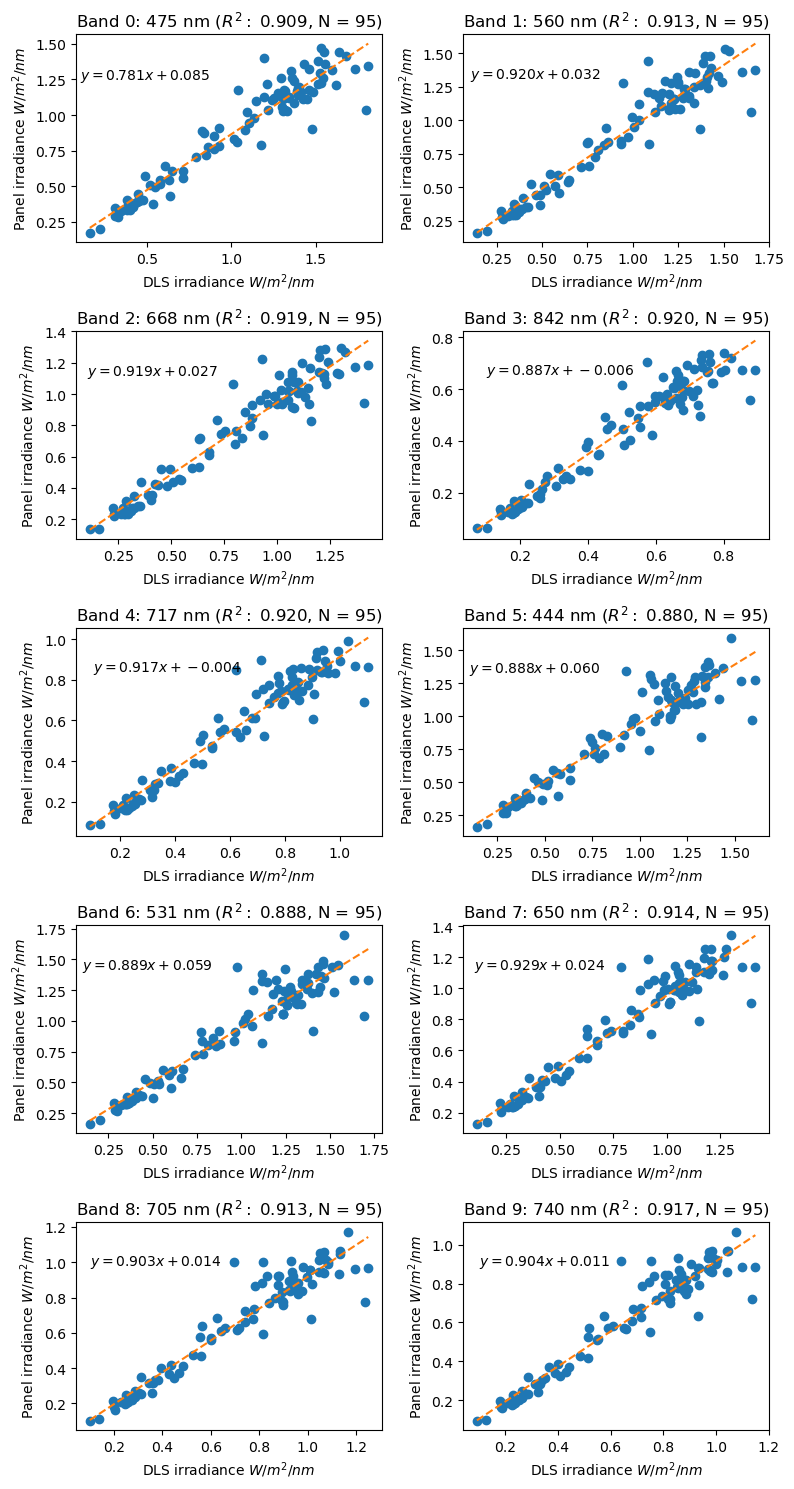

In [45]:
RC = rcu.RadiometricCorrection(dls_panel_irr,center_wavelengths,dls_panel_irr_calibration=None)
RC.plot()

# Import panel capture

In [50]:
dir_fp = list(panel_fp.keys())[0]
cap_fp = panel_fp[dir_fp][0]
print(dir_fp)
print(cap_fp) # already sorted by band in panel_fp
panel_radiance = rcu.get_panel_radiance(cap_fp)
panel_irradiance = [mutils.panel_radiance_to_irradiance(radiance,albedo) for radiance, albedo in zip(panel_radiance,panel_albedo)] #panel_radiance*np.pi/panel_albedo
print(panel_radiance)
print(panel_irradiance) #same result as capture.panel_irradiance()
# in CorrectionFactor, we need panel_radiance, so we do not need to repeat the whole internal process to compute panel_irradiance again

D:\EPMC_flight\10thSur24Aug\F1\RawImg
['D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_1.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_2.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_3.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_4.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_5.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_6.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_7.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_8.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_9.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0000_10.tif']
[0.14419940967335684, 0.14471271888042647, 0.12094172591079055, 0.06896841919866718, 0.0929759757107048, 0.15087091514665077, 0.1612072629085932, 0.1277203362299739, 0.1114749870194063, 0.1025448013702902]
[0.9415761103285069, 0.9468795081555529, 0.7934240877207821, 0.45438546360628734, 0.6106870676172149, 0.984398928315953, 1.054063304861448, 0.83

# Import image

In [51]:
image_names = glob.glob(os.path.join(dir_fp,'IMG_0005_*.tif'))
image_names = mutils.order_bands_from_filenames(image_names)
print(image_names)
cap = capture.Capture.from_filelist(image_names)
cap.dls_irradiance()
# cap.plot_undistorted_reflectance(panel_irradiance) #undistorted_reflectance

['D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_1.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_2.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_3.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_4.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_5.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_6.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_7.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_8.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_9.tif', 'D:\\EPMC_flight\\10thSur24Aug\\F1\\RawImg\\IMG_0005_10.tif']


[1.0643174451810307,
 0.9915088948132738,
 0.8512446233725081,
 0.5399523524368427,
 0.6595584836155162,
 0.9461771392822266,
 1.0145120239257812,
 0.8421327972412109,
 0.7438098907470704,
 0.6823016357421875]

# Get correction factor based on `panel_radiance`

In [4]:
dls_panel_irr_calibration

{0: {'coeff': 0.794482967277395,
  'intercept': 0.0826166734298549,
  'r2': 0.9091475666942727},
 1: {'coeff': 0.9349464216803856,
  'intercept': 0.029041140325149706,
  'r2': 0.9131268206301876},
 2: {'coeff': 0.9334028646920852,
  'intercept': 0.025008797522071635,
  'r2': 0.9174118043952513},
 3: {'coeff': 0.9004823913322649,
  'intercept': -0.007246811153201194,
  'r2': 0.9169164552742319},
 4: {'coeff': 0.9305823408177311,
  'intercept': -0.005411008132546136,
  'r2': 0.9197804683585011},
 5: {'coeff': 0.902195854315485,
  'intercept': 0.05779726285608122,
  'r2': 0.8871129493760002},
 6: {'coeff': 0.903038862510149,
  'intercept': 0.05651764445678786,
  'r2': 0.8949718956197986},
 7: {'coeff': 0.9439302752915522,
  'intercept': 0.022411152763590847,
  'r2': 0.9159599785920617},
 8: {'coeff': 0.9169538304313286,
  'intercept': 0.012366986497306054,
  'r2': 0.9166936081248183},
 9: {'coeff': 0.9174597854733466,
  'intercept': 0.009746667112236596,
  'r2': 0.920179331105901}}

Irradiance samples on sunny and cloudy days have different value ranges but follow a linear relationship in each band. Therefore, a universal DLS-CRP regression over all weather conditions can be achieved. The regression slopes are < 1.0 because the DLS recorded irradiance is higher than the CRP-converted irradiance in all weather conditions.

This makes sense because DLS is measuring the irradiance atop the drone directly, while panel irradiance is calculated and light may go through more scattering along the path

The coefficients obtained from `dls_panel_irr_calibration` is then used to extract the correction factor for each band. With the universal coefficients determined in this study, the at-sensor correction can be performed concerning all sUAS images in each flight mission by extracting the mission-specific CRP radiance from the calibration panel image. The correction factor is thus determined for each mission

![calibration regression](example_images/L_crp_L_dls_1.png)

# Discussion

- Bug encountered with panel_albedo reporting different reflectance values. see [here](https://github.com/micasense/imageprocessing/issues/196)
- The radiometric and model fitting was repeated with no fixed `panel_albedo` (i.e. loaded from *saved_data/panel_albedo.ob*)
- `panel_albedo` was then inferred from the QR images from the panel images, rather than using fixed albedo values
- It was found that using fixed albedo values from *saved_data/panel_albedo.ob* generally has better results, where $R^2$ was generally higher for most bands.
- Conclusion: continue using data from *saved_data*

![calibration regression for fixed albedo values](example_images/L_crp_L_dls_1.png)

calibration regression for fixed albedo values

![calibration regression from QR panel](example_images/L_crp_L_dls_2.png)

calibration regression from QR panel